# Decision Trees and Decision Tree Ensembles for ENSO Prediction
David John Gagne

In [206]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sys
import cartopy.crs as ccrs
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
sys.path.append('../utils/')
from ENSO_utils import get_data, get_nino34, plot_nino34, get_nino34events, split_data, standardize_data, make_cat, plot_input, plot_inputvector, plot_datasplit, plot_datasplitcat
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

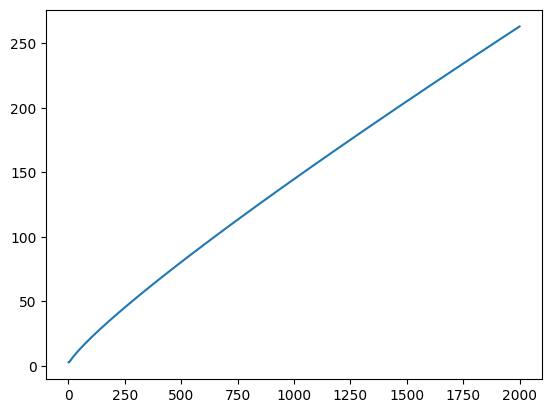

In [220]:
n = np.arange(2, 2000)
logn = np.log(n)
plt.plot(n, n / logn)

In [14]:
def get_nino34(sst):
    ninolat1 = -5
    ninolat2 = 5
    ninolon1 = 190
    ninolon2 = 240
    
    sstnino = sst.sel(lat=slice(ninolat1, ninolat2),lon=slice(ninolon1, ninolon2))
    print(sstnino)
    nino34 = sstnino["sst"].mean(dim=("lon", "lat")).values
    return nino34

<xarray.Dataset> Size: 900kB
Dimensions:  (time: 859, lat: 5, lon: 26)
Coordinates:
  * time     (time) object 7kB 1950-06-01 00:00:00 ... 2021-12-15 00:00:00
  * lat      (lat) float64 40B -4.0 -2.0 0.0 2.0 4.0
  * lon      (lon) float64 208B 190.0 192.0 194.0 196.0 ... 236.0 238.0 240.0
Data variables:
    sst      (time, lat, lon) float64 893kB -1.045 -1.105 ... -0.5369 -0.5423


Text(0, 0.5, 'Nino 3.4 Index')

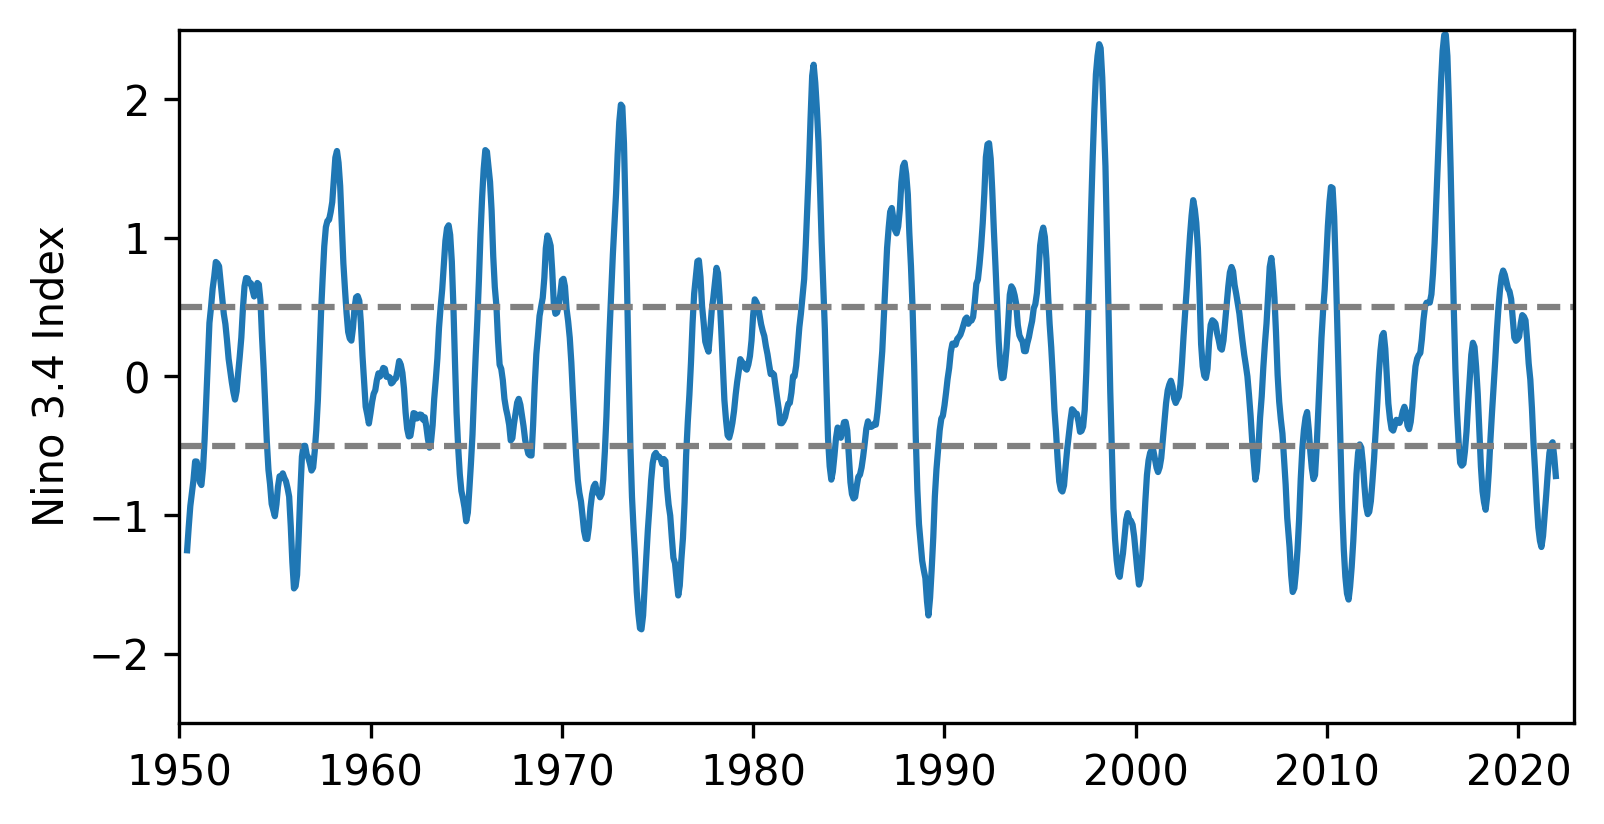

In [16]:
sst_all = xr.open_dataset("../utils/ERSSTv5_deseasoneddetrended_5monthrunningmean_1950-2021.nc")

# Preprocess ANN Input Data:
sst = sst_all.where((sst_all.lat <= 30) & (sst_all.lat >= -30), drop=True)
lat = sst.lat
lon = sst.lon
time = sst.time

# Preprocess ANN Output Data:
nino34 = get_nino34(sst)
times = pd.DatetimeIndex([t.isoformat() for t in sst.time.values])

plt.figure(figsize=(6, 3), dpi=300)
plt.plot(times, nino34)
plt.hlines(0.5,pd.Timestamp("1950-01-01"),pd.Timestamp("2022-12-01"),linestyle='dashed',color='grey')
plt.hlines(-0.5,pd.Timestamp("1950-01-01"),pd.Timestamp("2022-12-01"),linestyle='dashed',color='grey')
plt.ylim(-2.5,2.5)
plt.xlim(pd.Timestamp("1950-01-01"),pd.Timestamp("2022-12-01"))
plt.ylabel("Nino 3.4 Index")

In [138]:
# Grab only El Nino and La Nina samples from input & output
enso_magnitude = 0
lag = 3
sst_arr = sst["sst"].values
# NOTE: this function vectorizes the input
x,y = get_nino34events(sst_arr, nino34, enso_magnitude, vectorize=True)
wet_mask = ~np.isnan(x[0])
x_wet = x[:, wet_mask]
# Split data:
num_samples = y[lag:].shape[0]
train_val_test = [0.7,0.85,1] # set train/val/test fraction
xtrain, xval, xtest, ytrain, yval, ytest, trainind, valind, testind = split_data(num_samples,
                                                                                 train_val_test,
                                                                                 x_wet[:-lag],
                                                                                 y[lag:])


In [158]:
dt = DecisionTreeRegressor(max_depth=3)
dt.fit(xtrain, ytrain)

DecisionTreeRegressor(max_depth=3)

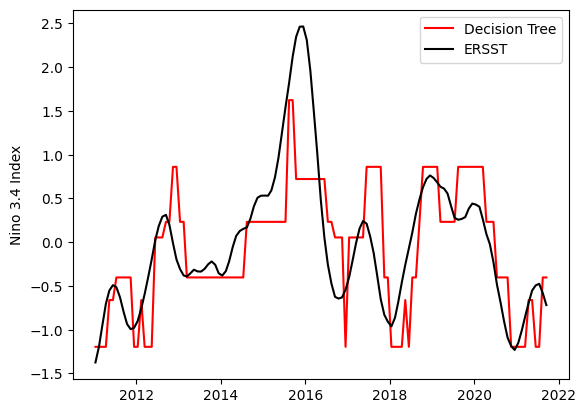

In [161]:
plt.plot(times[testind],dt.predict(xtest), color='r', label="Decision Tree")
plt.plot(times[testind], ytest, color='k', label="ERSST")
plt.ylabel("Nino 3.4 Index")
plt.legend()
plt.savefig("dt_enso_pred.png", dpi=300, bbox_inches="tight")

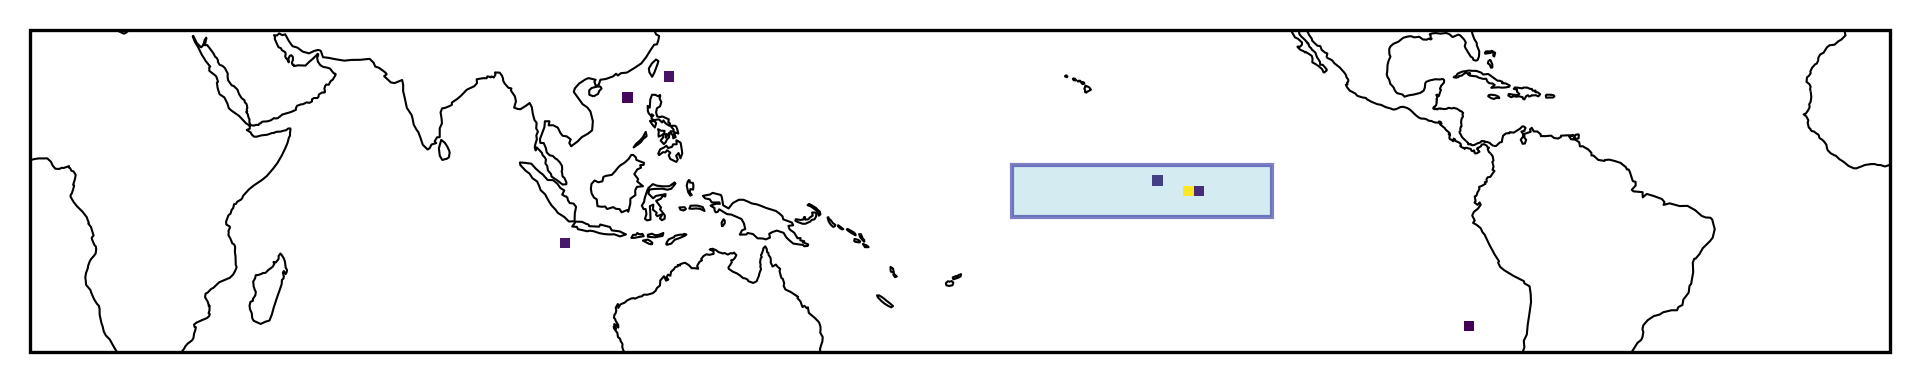

In [165]:
fi = dt.feature_importances_
fi_grid = np.zeros(wet_mask.shape)
fi_grid[wet_mask] = fi
fi_grid = fi_grid.reshape(lat.size, lon.size)
proj = ccrs.PlateCarree(central_longitude=180)
transform = ccrs.PlateCarree(central_longitude=0)
fig, ax= plt.subplots(1, 1, figsize=(8, 5), dpi=300, subplot_kw=dict(projection=proj))
ax.coastlines(lw=0.5)
ninolat1 = -5
ninolat2 = 5
ninolon1 = 190
ninolon2 = 240

rect = patches.Rectangle((ninolon1, ninolat1), ninolon2-ninolon1, ninolat2-ninolat1, 
                         linewidth=1, 
                         edgecolor='darkblue', 
                         facecolor='lightblue', 
                         alpha=0.5, transform=transform)
ax.add_patch(rect)
ax.pcolormesh(lon, lat, np.ma.array(fi_grid, mask=fi_grid==0), cmap="viridis", transform=transform)
plt.savefig("feature_importances.png", dpi=300, bbox_inches="tight")


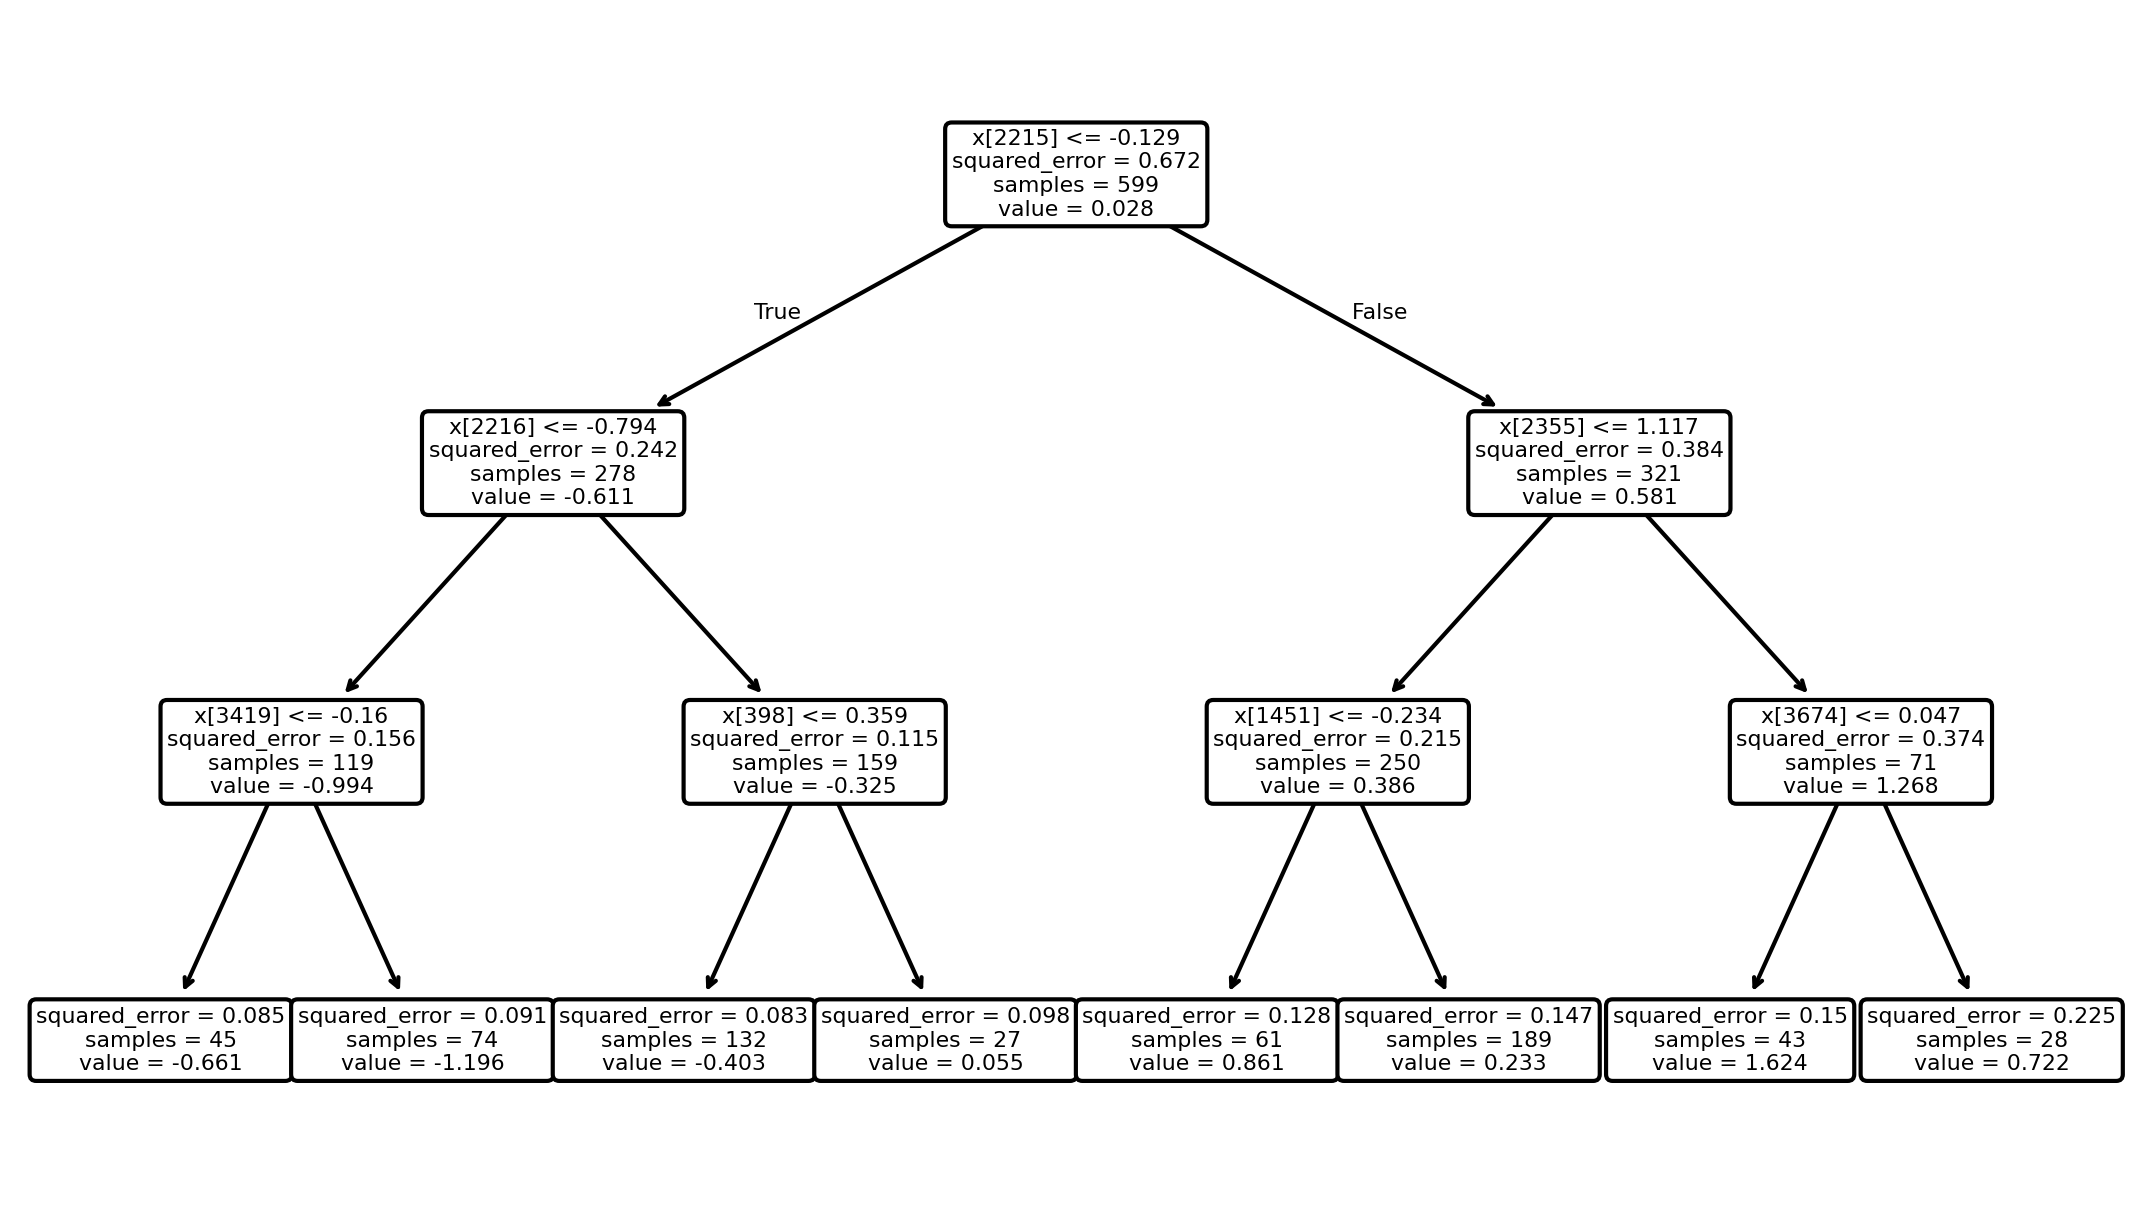

In [166]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5), dpi=300)
_ = plot_tree(dt, max_depth=5, ax=ax, rounded=True, )

In [178]:
scaler = StandardScaler()
pc = PCA(n_components=10)
xtrain_norm = scaler.fit_transform(xtrain)
xval_norm = scaler.transform(xval)
xtest_norm = scaler.transform(xtest)
xtrain_pc = pc.fit_transform(xtrain_norm)
xval_pc = pc.transform(xval_norm)
xtest_pc = pc.transform(xtest_norm)

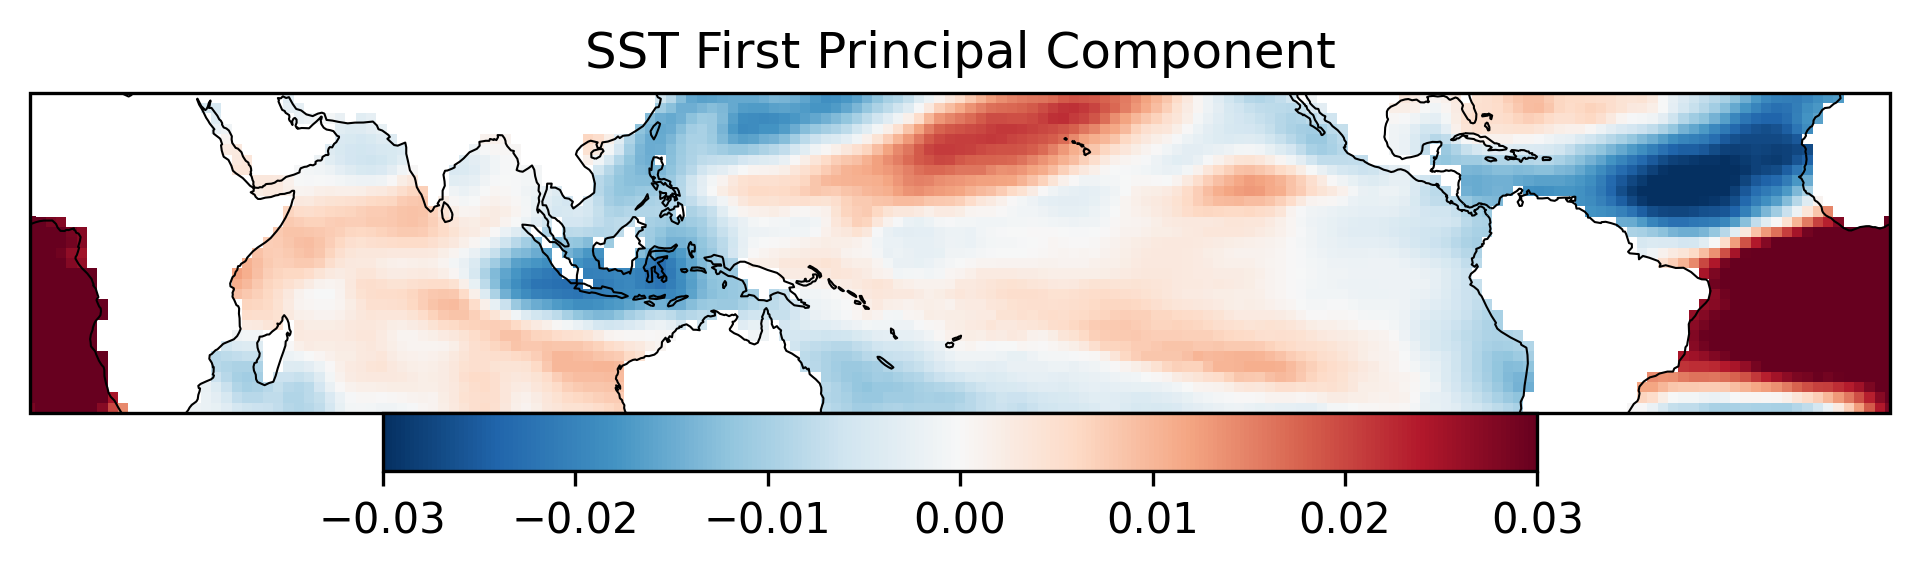

In [189]:
fi = pc.components_[3]
fi_grid = np.zeros(wet_mask.shape)
fi_grid[wet_mask] = fi
fi_grid = fi_grid.reshape(lat.size, lon.size)
proj = ccrs.PlateCarree(central_longitude=180)
transform = ccrs.PlateCarree(central_longitude=0)
fig, ax= plt.subplots(1, 1, figsize=(8, 5), dpi=300, subplot_kw=dict(projection=proj))
ax.coastlines(lw=0.5)
ninolat1 = -5
ninolat2 = 5
ninolon1 = 190
ninolon2 = 240

rect = patches.Rectangle((ninolon1, ninolat1), ninolon2-ninolon1, ninolat2-ninolat1, 
                         linewidth=1, 
                         edgecolor='darkblue', 
                         facecolor='lightblue', 
                         alpha=0.5, transform=transform)
ax.add_patch(rect)
img =  ax.pcolormesh(lon, lat, np.ma.array(fi_grid, mask=fi_grid==0), cmap="RdBu_r", transform=transform, vmin=-0.03, vmax=0.03)
plt.colorbar(img, ax=ax, orientation="horizontal", pad=0, fraction=0.05)
plt.title("SST First Principal Component")
plt.savefig("pc_viz.png", dpi=300, bbox_inches="tight")

In [194]:
dt_pca = DecisionTreeRegressor(max_depth=10)
dt_pca.fit(xtrain_pc, ytrain)

DecisionTreeRegressor(max_depth=10)

In [203]:
rf_pca = RandomForestRegressor(n_estimators=10)
rf_pca.fit(xtrain_pc, ytrain)

RandomForestRegressor(n_estimators=10)

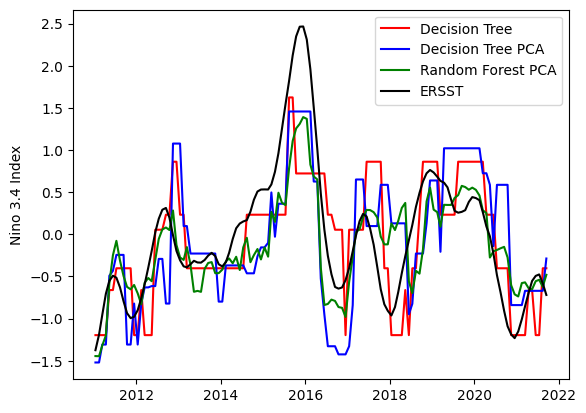

In [204]:
plt.plot(times[testind],dt.predict(xtest), color='r', label="Decision Tree")
plt.plot(times[testind],dt_pca.predict(xtest_pc), color='b', label="Decision Tree PCA")
plt.plot(times[testind],rf_pca.predict(xtest_pc), color='g', label="Random Forest PCA")
plt.plot(times[testind], ytest, color='k', label="ERSST")
plt.ylabel("Nino 3.4 Index")
plt.legend()
plt.savefig("dt_enso_pred.png", dpi=300, bbox_inches="tight")

In [197]:
dt_pca.feature_importances_

array([0.4341725 , 0.23434358, 0.10722077, 0.0138886 , 0.01888292,
       0.07923096, 0.03217408, 0.03167032, 0.02892959, 0.01948668])

In [205]:
rf_pca.feature_importances_

array([0.45077046, 0.21529313, 0.11232966, 0.01852157, 0.01286291,
       0.05682595, 0.04412146, 0.04265597, 0.02309096, 0.02352793])